In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sktime.transformations.panel.rocket import Rocket, MiniRocket
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import joblib

# Load the dataset
data = pd.read_csv('../../00_Data_Input/relabelled_data_ksa_explore.csv')

# Preparing data for modeling
X = data[[f'VH_{i}' for i in range(31)]]
y = data['observation']
y = y.astype(int)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert the data to nested DataFrame format required by sktime
X_train_nested = from_2d_array_to_nested(X_train.to_numpy())
X_test_nested = from_2d_array_to_nested(X_test.to_numpy())

# # Visualizing example series from each class
# classes = y.unique()
# plt.figure(figsize=(14, 8))
# for i, class_label in enumerate(classes):
#     plt.subplot(len(classes), 1, i + 1)
#     example_series = X_train[y_train == class_label].iloc[0]
#     plt.plot(example_series)
#     plt.title(f"Example Series from Class: {class_label}")
#     plt.grid(True)
# plt.tight_layout()
# plt.show()

In [17]:
def train_model_with_params(X_train, y_train, X_test, y_test, method='rocket', model_type='ridge',
                            num_kernels=10000, alpha=1.0, solver='auto', fit_intercept=True, max_iter=100,
                            n_estimators=100, random_state=42, learning_rate='optimal', eta0=0.01,
                            model_filename='best_model.pkl'):
    # Select transformation method
    if method == 'rocket':
        transformer = Rocket(num_kernels=num_kernels)
    elif method == 'minirocket':
        transformer = MiniRocket(num_kernels=num_kernels)
    else:
        raise ValueError("Method should be either 'rocket' or 'minirocket'.")

    # Select model type
    if model_type == 'ridge':
        model = RidgeClassifier(alpha=alpha, solver=solver, fit_intercept=fit_intercept, max_iter=max_iter)
    elif model_type == 'logistic_sgd':
        model = SGDClassifier(loss='log_loss', learning_rate=learning_rate, eta0=eta0, max_iter=max_iter, random_state=random_state)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    else:
        raise ValueError("Model type should be either 'ridge', 'logistic_sgd', or 'random_forest'.")

    # Create a pipeline with the selected transformer and model
    pipeline = make_pipeline(transformer, model)

    # Train the model
    pipeline.fit(X_train, y_train)

    # Save the model to a file
    joblib.dump(pipeline, model_filename)
    print(f"Model saved as {model_filename}")

    # Evaluate the model on the test set
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test) if hasattr(pipeline, "predict_proba") else None

    # Classification report
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_type.capitalize()} ({method.capitalize()})")
    plt.show()

    # If probabilities are available, display the first few
    if y_prob is not None:
        print("Predicted Probabilities:")
        print(pd.DataFrame(y_prob, columns=np.unique(y_train)).head())

def plot_confusion_matrix_with_percentages(y_true, y_pred, labels):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Compute percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create a figure
    plt.figure(figsize=(10, 8))
    
    # Use seaborn heatmap to display the matrix with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    
    # Overlay the percentages
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, f'{cm_percentage[i, j]:.2f}%\n({cm[i, j]})',
                     ha='center', va='center', color='black', fontsize=10)
    
    plt.title("Confusion Matrix with Percentages and Counts")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Model saved as minirocket_ridge_model.pkl


/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.56      0.66      0.61       124
           2       0.49      0.39      0.43       100
           3       0.58      0.69      0.63       155
           4       0.61      0.69      0.65       185
           5       0.52      0.44      0.48       104
           6       0.56      0.66      0.61        47
           7       1.00      0.18      0.30        17

    accuracy                           0.57       767
   macro avg       0.54      0.46      0.46       767
weighted avg       0.55      0.57      0.55       767



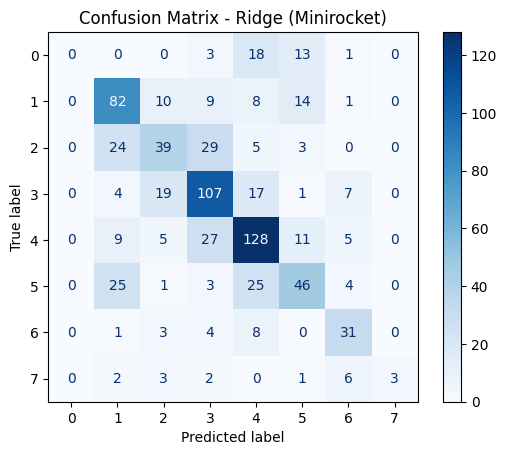

In [19]:
# Example usage for RidgeClassifier with MiniRocket
train_model_with_params(X_train_nested, y_train, X_test_nested, y_test, method='minirocket', model_type='ridge',
                        num_kernels=10000, alpha=100, solver='auto', fit_intercept=True, max_iter=300,
                        model_filename='minirocket_ridge_model.pkl')

# # Example usage for RidgeClassifier with Rocket
# train_model_with_params(X_train_nested, y_train, X_test_nested, y_test, method='rocket', model_type='ridge',
#                         num_kernels=10000, alpha=100, solver='auto', fit_intercept=True, max_iter=300,
#                         model_filename='rocket_ridge_model.pkl')

# # Example usage for Logistic Regression with SGD and MiniRocket
# train_model_with_params(X_train_nested, y_train, X_test_nested, y_test, method='minirocket', model_type='logistic_sgd',
#                         num_kernels=5000, max_iter=500, learning_rate='optimal', eta0=0.01, model_filename='rocket_ridge_model.pkl')

# # Example usage for RandomForestClassifier with Rocket
# train_model_with_params(X_train_nested, y_train, X_test_nested, y_test, method='rocket', model_type='random_forest',
#                         num_kernels=10000, n_estimators=200, random_state=42, model_filename='rocket_ridge_model.pkl')

In [ ]:
# Hyperparameter Tuning with GridSearchCV
def tune_hyperparameters(X_train, y_train, method='rocket', model_type='logistic_sgd', save_best_model=True, model_filename='best_tuned_model.pkl'):
    if method == 'rocket':
        transformer = Rocket()
    elif method == 'minirocket':
        transformer = MiniRocket()
    else:
        raise ValueError("Method should be either 'rocket' or 'minirocket'.")

    if model_type == 'logistic_sgd':
        model = SGDClassifier(loss='log_loss', random_state=42)
        param_grid = {
            'rocket__num_kernels': [5000, 10000],
            'sgdclassifier__learning_rate': ['optimal', 'invscaling', 'constant'],
            'sgdclassifier__eta0': [0.001, 0.01, 0.1],
            'sgdclassifier__max_iter': [1000, 2000]
        }
    elif model_type == 'ridge':
        model = RidgeClassifier()
        param_grid = {
            'rocket__num_kernels': [5000, 10000],
            'ridgeclassifier__alpha': [0.1, 1.0, 10.0],
            'ridgeclassifier__solver': ['auto', 'lsqr', 'sag'],
            'ridgeclassifier__max_iter': [300, 500]
        }
    elif model_type == 'random_forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'rocket__num_kernels': [5000, 10000],
            'randomforestclassifier__n_estimators': [100, 200],
            'randomforestclassifier__max_depth': [None, 10, 20]
        }
    else:
        raise ValueError("Model type should be either 'logistic_sgd', 'ridge', or 'random_forest'.")

    pipeline = make_pipeline(transformer, model)

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=10, verbose=2)
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters for {model_type.capitalize()}: {grid_search.best_params_}")
    print(f"Best Cross-validation Score for {model_type.capitalize()}: {grid_search.best_score_}")

    if save_best_model:
        joblib.dump(grid_search.best_estimator_, model_filename)
        print(f"Best model saved as {model_filename}")

    return grid_search

# Example hyperparameter tuning for Logistic Regression with SGD
tuned_model = tune_hyperparameters(X_train_nested, y_train, method='minirocket', model_type='logistic_sgd',
                                   save_best_model=True, model_filename='minirocket_logistic_sgd_tuned_model.pkl')

# Evaluate the tuned model on the test set
y_pred = tuned_model.predict(X_test_nested)
y_prob = tuned_model.predict_proba(X_test_nested) if hasattr(tuned_model, "predict_proba") else None

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Tuned Model")
plt.show()

# If probabilities are available, display the first few
if y_prob is not None:
    print("Predicted Probabilities:")
    print(pd.DataFrame(y_prob, columns=np.unique(y_train)).head())

In [ ]:
# import joblib
# import pandas as pd
# from sktime.datatypes._panel._convert import from_2d_array_to_nested

# # Fungsi untuk memuat model dari file .pkl
# def load_model(model_filename):
#     model = joblib.load(model_filename)
#     print(f"Model loaded from {model_filename}")
#     return model

# # Contoh penggunaan
# # Menggunakan model yang telah disimpan
# loaded_model = load_model('minirocket_logistic_sgd_tuned_model.pkl')

# # Contoh data baru (harus dalam format yang sama dengan data pelatihan)
# # Misalkan kita memiliki dataset baru dalam file CSV
# new_data = pd.read_csv('path_to_new_data.csv')  # Ganti dengan path file data baru Anda
# X_new = new_data[[f'VH_{i}' for i in range(31)]]

# # Konversi data baru menjadi nested DataFrame yang diperlukan oleh sktime
# X_new_nested = from_2d_array_to_nested(X_new.to_numpy())

# # Aplikasi model yang dimuat untuk prediksi pada data baru
# y_new_pred = loaded_model.predict(X_new_nested)
# y_new_prob = loaded_model.predict_proba(X_new_nested) if hasattr(loaded_model, "predict_proba") else None

# # Output prediksi
# print("Prediksi kelas untuk data baru:")
# print(y_new_pred)

# # Jika probabilitas tersedia, tampilkan probabilitasnya
# if y_new_prob is not None:
#     print("Probabilitas prediksi untuk data baru:")
#     print(pd.DataFrame(y_new_prob, columns=loaded_model.classes_))

/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RidgeClassifier was fitted without feature names
  warnings.warn(
/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        33
         1.0       0.24      0.87      0.38       109
         2.0       0.00      0.00      0.00        97
         3.0       0.00      0.00      0.00       151
         4.0       0.40      0.79      0.53       190
         5.0       0.00      0.00      0.00       106
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        23

    accuracy                           0.32       767
   macro avg       0.08      0.21      0.11       767
weighted avg       0.13      0.32      0.19       767



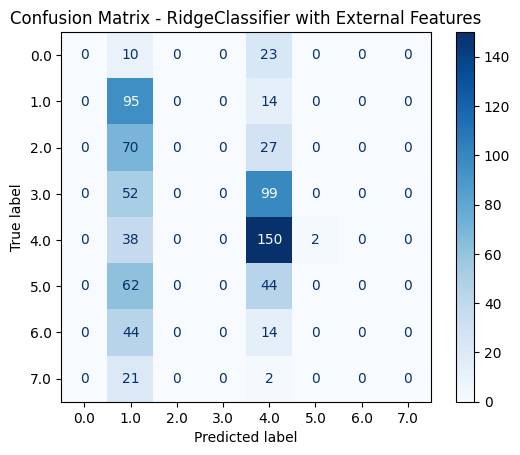

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report

X = data[[f'F{i}' for i in range(1,18)]]
y = data['observation']

# Convert string to float
X = X.replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')

# Remove rows with any NaN values
X = X.dropna()
y = y[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the RidgeClassifier
ridge_clf = RidgeClassifier()
ridge_clf.fit(X_train_scaled, y_train)

# Predict and evaluate the model
y_pred = ridge_clf.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RidgeClassifier with External Features")
plt.show()

Model saved as minirocket_ridge_with_external_features.pkl
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.57      0.66      0.61       124
           2       0.52      0.47      0.49       100
           3       0.57      0.66      0.61       155
           4       0.61      0.71      0.66       185
           5       0.57      0.47      0.52       104
           6       0.51      0.55      0.53        47
           7       1.00      0.12      0.21        17

    accuracy                           0.57       767
   macro avg       0.54      0.46      0.45       767
weighted avg       0.55      0.57      0.55       767



/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

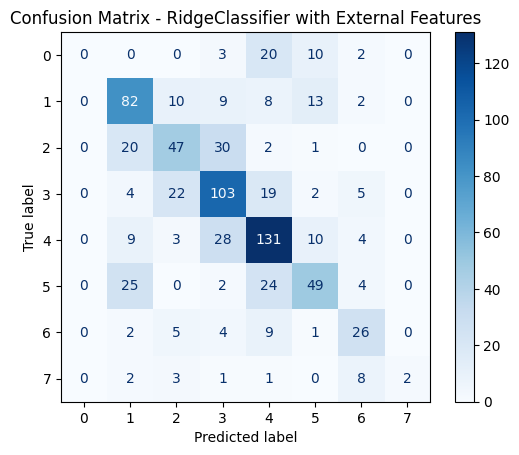

Decision function values:
          0         1         2         3         4         5         6  \
0 -0.985915 -1.022639 -0.912604 -0.108815 -0.239448 -0.982032 -0.727716   
1 -1.021983 -0.012828  0.092486 -0.769944 -1.200785 -1.037348 -1.009602   
2 -0.806349 -0.631361 -0.884270 -1.128383  0.029544 -0.837305 -0.872350   
3 -0.919142 -0.729797 -0.876114 -0.842115 -0.467476 -0.998207 -0.429373   
4 -0.860764 -1.162718 -1.217243 -0.461607 -0.132791 -0.836730 -0.458796   

          7  
0 -1.020831  
1 -1.039996  
2 -0.869526  
3 -0.737776  
4 -0.869352  


In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sktime.transformations.panel.rocket import Rocket, MiniRocket
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import joblib

# Load the dataset
data = pd.read_csv('../../00_Data_Input/relabelled_data_ksa_explore.csv')

# Assume external features dataframe df_external has been provided with columns F1 to F7
df_external = data[[f'F{i}' for i in range(1,18)]]


# Preparing data for modeling
X = data[[f'VH_{i}' for i in range(31)]]
X = X.replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')

y = data['observation']
y = data['observation'].astype(int)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
df_external_train, df_external_test = train_test_split(df_external, test_size=0.2, random_state=42, stratify=y)

# Convert the data to nested DataFrame format required by sktime
X_train_nested = from_2d_array_to_nested(X_train.to_numpy())
X_test_nested = from_2d_array_to_nested(X_test.to_numpy())

# Apply MiniRocket transformation
minirocket = MiniRocket(num_kernels=5000)
X_train_transformed = minirocket.fit_transform(X_train_nested)
X_test_transformed = minirocket.transform(X_test_nested)

# Convert transformed data to DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

# Combine transformed data with external features
X_train_combined = pd.concat([X_train_transformed_df, df_external_train.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test_transformed_df, df_external_test.reset_index(drop=True)], axis=1)

# Convert column names to strings
X_train_transformed_df.columns = X_train_transformed_df.columns.astype(str)
X_test_transformed_df.columns = X_test_transformed_df.columns.astype(str)
df_external_train.columns = df_external_train.columns.astype(str)
df_external_test.columns = df_external_test.columns.astype(str)

# Combine transformed data with external features
X_train_combined = pd.concat([X_train_transformed_df, df_external_train.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test_transformed_df, df_external_test.reset_index(drop=True)], axis=1)


X_train_combined = X_train_combined.replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')
X_test_combined = X_test_combined.replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')

# Building a RidgeClassifier model
model = RidgeClassifier(alpha=100, solver='auto', fit_intercept=True, max_iter=300)

# Train the model on the combined dataset
model.fit(X_train_combined, y_train)

# Save the model to a file
model_filename = 'minirocket_ridge_with_external_features.pkl'
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")

# Evaluate the model on the test set
y_pred = model.predict(X_test_combined)
y_prob = model.decision_function(X_test_combined) if hasattr(model, "decision_function") else None

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RidgeClassifier with External Features")
plt.show()

# If probabilities are available, display the first few
if y_prob is not None:
    print("Decision function values:")
    print(pd.DataFrame(y_prob).head())